# Setup

In [1]:
# !git clone https://github.com/Sopralapanca/medium-skill-based-agents.git
# %cd /content/medium-skill-based-agents
# !ls

In [2]:
# !uv pip install -r pyproject.toml

In [3]:
# !python create_dataset.py

In [4]:
# !python train_vos.py
# !python train_vok.py
# !python train_usr.py

Import the required packages, build the environment and test if it works

In [5]:
# general imports
import torch
import yaml
import numpy as np
import random
import os

# training imports
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage

import matplotlib.pyplot as plt

# IMPORTANT - REGISTER THE ENVIRONMENTS
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

# Load config
_config_path = "./configs.yaml"

_config = {}
with open(_config_path, "r") as f:
    _config = yaml.safe_load(f) or {}


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # ignore tensorflow warnings about CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

seed = None
if seed is not None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


#envs = _config.get("ENVS", ["PongNoFrameskip-v4"])[0]
env = "PongNoFrameskip-v4"
with open(f'environment_configs/{env}.yaml', 'r') as file:
        environment_configuration = yaml.safe_load(file)["config"]

2025-12-27 15:58:45.253914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/giacomo/Documents/code-projects/medium-skill-based-agents/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium

In [6]:
def create_env(env_id, configs, seed=None):
    env = make_atari_env(env_id, n_envs=configs["n_envs"], seed=seed)
    env = VecFrameStack(env, n_stack=configs["n_stacks"])
    env = VecTransposeImage(env)
    return env

In [7]:
import wandb
from dotenv import load_dotenv

load_dotenv()


key = os.getenv("WANDB_API_KEY")
if key is None:
    raise ValueError("WANDB_API_KEY not set")

def init_wandb(environment_configuration):
  wandb.login(key=key)

  tags = [
      f"fe:{environment_configuration['f_ext_name']}",
      f"game:{environment_configuration['game']}",
  ]

  run = wandb.init(
      project="medium-skill-based-agents",
      config=environment_configuration,
      sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
      monitor_gym=False,  # auto-upload the videos of agents playing the game
      group=f"{environment_configuration['game']}",
      tags=tags
      # save_code = True,  # optional
  )

  return run

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


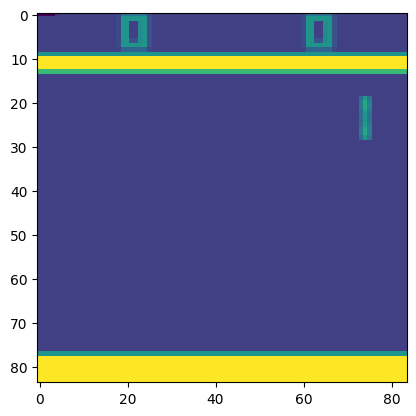

In [8]:
test_envs = create_env(env_id=env, configs=environment_configuration, seed=seed)

# execute some steps with random moves
obs = test_envs.reset()

for i in range(10):
    action = [test_envs.action_space.sample() for _ in range(environment_configuration["n_envs"])]
    obs, rewards, dones, info = test_envs.step(action)

# obs[0] has shape (4, 84, 84) because there are 4 stacked environments, take the first
observation = obs[0][-1]
plt.imshow(observation)
plt.show()



Utility function for training agents

In [9]:
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
from wandb.integration.sb3 import WandbCallback
from utils.custom_ppo import CustomPPO  # Use custom PPO with auxiliary loss support
from rl_zoo3.utils import linear_schedule
from utils.monitor_moe_weights import GatingMonitorCallback

def train_agent(env_id, configs, policy_kwargs, seed):
    
    #run = init_wandb(configs)
    logdir = "./tensorboard_logs"
    
    # monitor_dir = str(run.id)
    monitor_dir = "ppo"

    vec_envs = create_env(env_id=env_id, configs=configs, seed=seed)
    _ = vec_envs.reset()
    
    eval_envs = create_env(env_id=env_id, configs=configs, seed=None)

    model = CustomPPO(  # Changed from PPO to CustomPPO
        "CnnPolicy",
        vec_envs,
        learning_rate=linear_schedule(environment_configuration["learning_rate"]),
        n_steps=environment_configuration["n_steps"],
        n_epochs=environment_configuration["n_epochs"],
        batch_size=environment_configuration["batch_size"],
        clip_range=linear_schedule(environment_configuration["clip_range"]),
        normalize_advantage=environment_configuration["normalize"],
        ent_coef=environment_configuration["ent_coef"],
        vf_coef=environment_configuration["vf_coef"],
        policy_kwargs=policy_kwargs,
        verbose=0,
        device=device,
        tensorboard_log=logdir,
    )


    eval_logs = f"eval_logs/{env}/{monitor_dir}"
    os.makedirs(eval_logs, exist_ok=True)

    # eval_callback = EvalCallback(
    #     eval_envs,
    #     n_eval_episodes=100,
    #     best_model_save_path=f"./agents/{monitor_dir}",
    #     log_path=eval_logs,
    #     eval_freq=5000 * environment_configuration["n_envs"],
    #     verbose=0,
    # )
    
    
    callbacks = [
        #WandbCallback(verbose=0),
        # eval_callback
    ]

    if configs["f_ext_name"] == "moe_ext":
        # Get the feature extractor from the model
        feature_extractor = model.policy.features_extractor

        # Create monitoring callback
        gating_monitor = GatingMonitorCallback(
            feature_extractor=feature_extractor,
            env=env_id,
            save_freq=500,  # Save every 500 steps
            save_path="./gating_weights",
            verbose=0
        )
        
        callbacks.append(gating_monitor)
        
    model.learn(25000, callback=callbacks, progress_bar=True) #tb_log_name=run.id)
    #run.finish()


In [10]:
policy_kwargs = dict(
    net_arch={
        "pi": environment_configuration["net_arch_pi"],
        "vf": environment_configuration["net_arch_vf"],
    },
    # activation_fn=torch.nn.ReLU,  # use ReLU in case of multiple layers for the policy learning network
)

# Train Standard PPO Agent

In [11]:
#train_agent(env, environment_configuration, policy_kwargs, seed)

# Skills initialization

In [12]:
from skills.autoencoder import Autoencoder
from skills.unsupervised_state_representation import UnsupervisedStateRepresentationModel
from skills.video_object_keypoints import Transporter
from skills.video_object_segmentation import VideoObjectSegmentationModel

# init skills
autoencoder = Autoencoder(channels=1).to(device)

# observation has shape (32, 4, 84, 84),
# observation = obs[0][0][None, :, :] # (1, 84, 84)

print(obs[0].shape) # (4, 84, 84)

environment_configuration["f_ext_kwargs"]["device"] = device  #do not comment this, it is the parameter passed to the feature extractor
environment_configuration["game"] = env


usr = UnsupervisedStateRepresentationModel(observation=obs[0], device=device)
vok = Transporter().to(device)
vos = VideoObjectSegmentationModel(device=device)


skills = [
    usr.get_skill(device=device),
    vok.get_skill(device=device, keynet_or_encoder="encoder"),
    vok.get_skill(device=device, keynet_or_encoder="keynet"),
    vos.get_skill(device=device)
]

# Test each skill's input adapter
print("\nTesting skill input adapters:")
test_obs = obs[:1]  # Take one sample from batch
test_obs = torch.tensor(test_obs, dtype=torch.float32).to(device)

for skill in skills:
    print(f"\nSkill: {skill.name}")
    print(f"Input shape: {test_obs.shape}")
    adapted = skill.input_adapter(test_obs)
    print(f"After adapter: {adapted.shape}")

(4, 84, 84)


/home/giacomo/Documents/code-projects/medium-skill-based-agents/.venv/lib/python3.12/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Testing skill input adapters:

Skill: state_rep_uns
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 160, 210])

Skill: obj_key_enc
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 84, 84])

Skill: obj_key_key
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 84, 84])

Skill: vid_obj_seg
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 2, 84, 84])


# Train WSA agent

In [13]:
# from utils.feature_extractors import WeightSharingAttentionExtractor

# f_ext_kwargs = environment_configuration["f_ext_kwargs"]
# environment_configuration["f_ext_name"] = "wsharing_attention_ext"
# environment_configuration["f_ext_class"] = WeightSharingAttentionExtractor
# f_ext_kwargs["skills"] = skills
# f_ext_kwargs["features_dim"] = 256

# policy_kwargs["features_extractor_class"] = environment_configuration["f_ext_class"]
# policy_kwargs["features_extractor_kwargs"] = f_ext_kwargs

# train_agent(env, environment_configuration, policy_kwargs, seed)


# Train MOE agent

In [ ]:
# Example: Configure MoE with different exploration settings
from utils.feature_extractors import MixtureOfExpertsExtractor

f_ext_kwargs = environment_configuration["f_ext_kwargs"]
environment_configuration["f_ext_name"] = "moe_ext"
environment_configuration["f_ext_class"] = MixtureOfExpertsExtractor
f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256

# Exploration and load balancing parameters
f_ext_kwargs["exploration_noise_std"] = 0.5  # Try 0.01, 0.05, 0.1, 0.2
f_ext_kwargs["load_balance_coef"] = 0.05    # Try 0.001, 0.01, 0.05

policy_kwargs["features_extractor_class"] = environment_configuration["f_ext_class"]
policy_kwargs["features_extractor_kwargs"] = f_ext_kwargs

train_agent(env, environment_configuration, policy_kwargs, seed)

Output()

Loaded gating weights from 7 checkpoints
Number of experts: 4
Expert names: ['state_rep_uns', 'obj_key_enc', 'obj_key_key', 'vid_obj_seg']

Total steps recorded: 128200

Mean weights per expert:
  state_rep_uns: 0.4323
  obj_key_enc: 0.0038
  obj_key_key: 0.0010
  vid_obj_seg: 0.5629

Plot saved to ./gating_plots/gating_distribution_gating_weights_PongNoFrameskip-v4.png


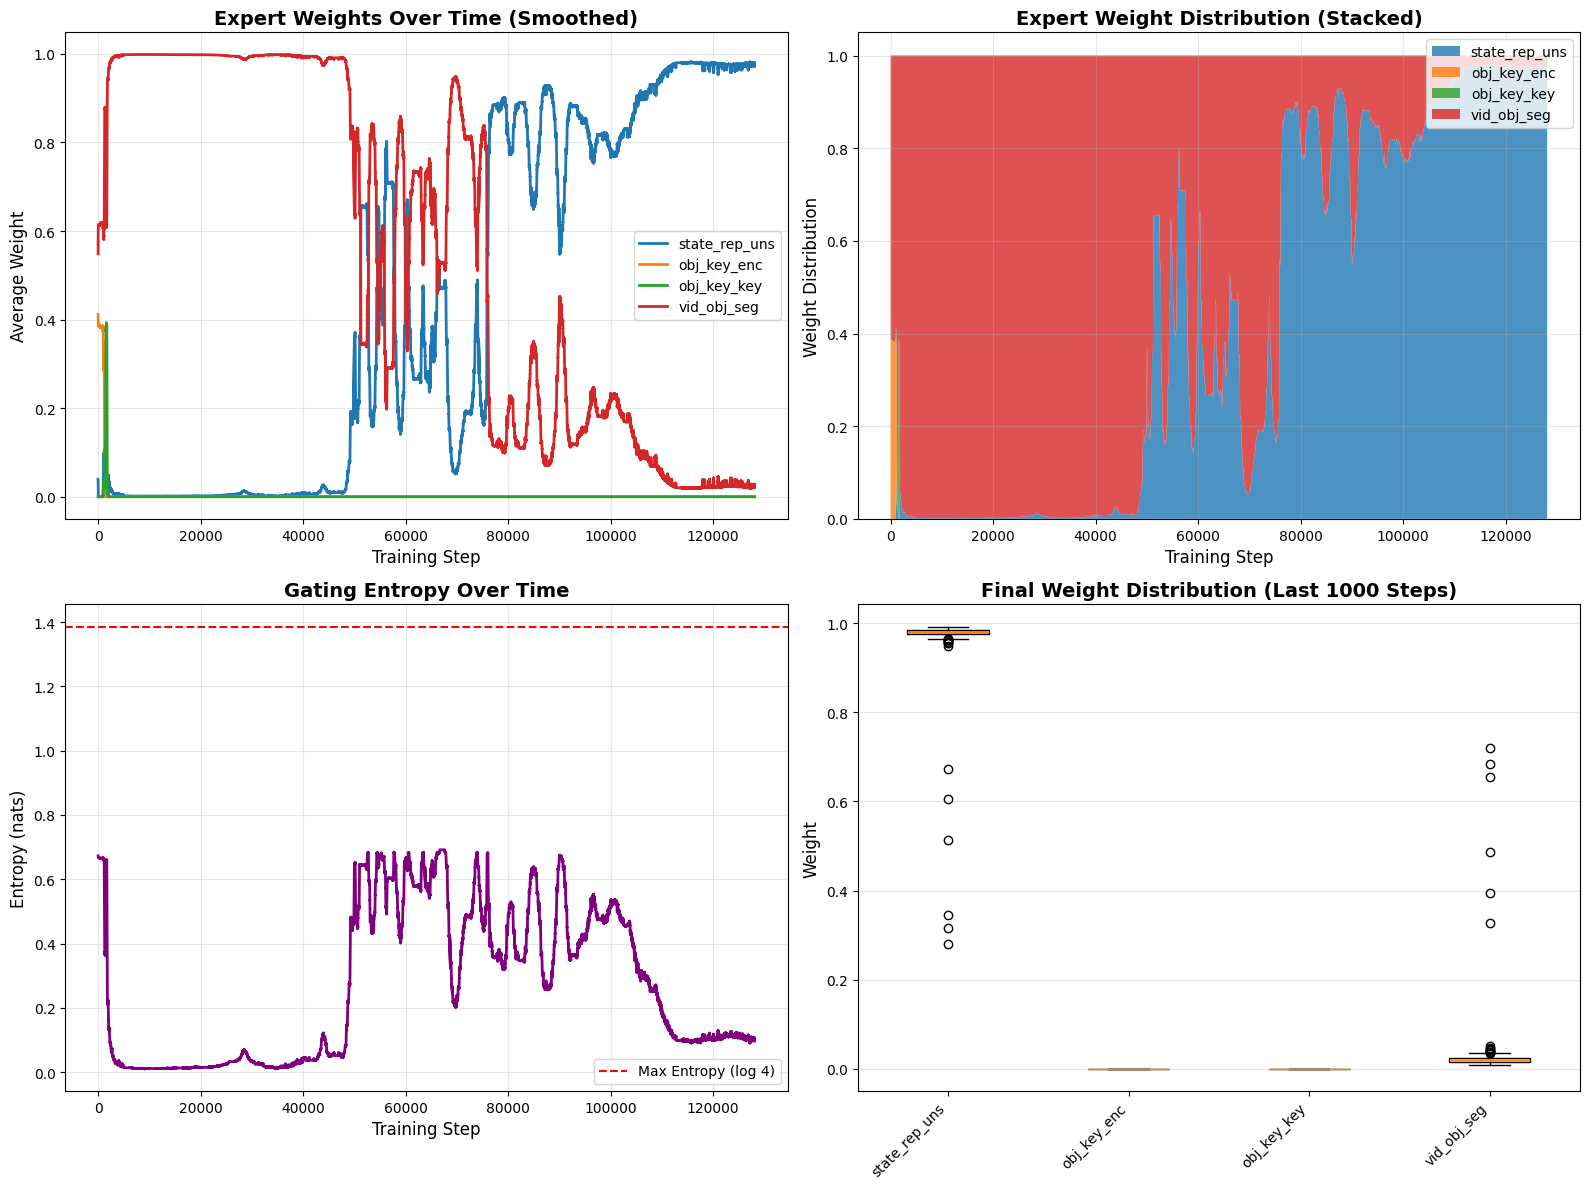


COLLAPSE ANALYSIS

Final mean weights:
  state_rep_uns: 0.9764
  obj_key_enc: 0.0000
  obj_key_key: 0.0000
  vid_obj_seg: 0.0236

Dominant expert: state_rep_uns (0.9764)

⚠️  WARNING: Possible collapse detected! Expert 'state_rep_uns' dominates with 97.6%


In [15]:
from utils.monitor_moe_weights import plot_gating_distribution
import os

env = "PongNoFrameskip-v4"

# Plot the results
weights_file = f"./gating_weights/gating_weights_{env}.pkl"
if os.path.exists(weights_file):
    plot_gating_distribution(weights_file, output_dir="./gating_plots")
else:
    raise FileNotFoundError(f"Warning: Weights file not found at {weights_file}")